# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [37]:
import cv2
import math
import numpy as np
from scipy.spatial import distance
from matplotlib import pyplot as plt
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display

plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

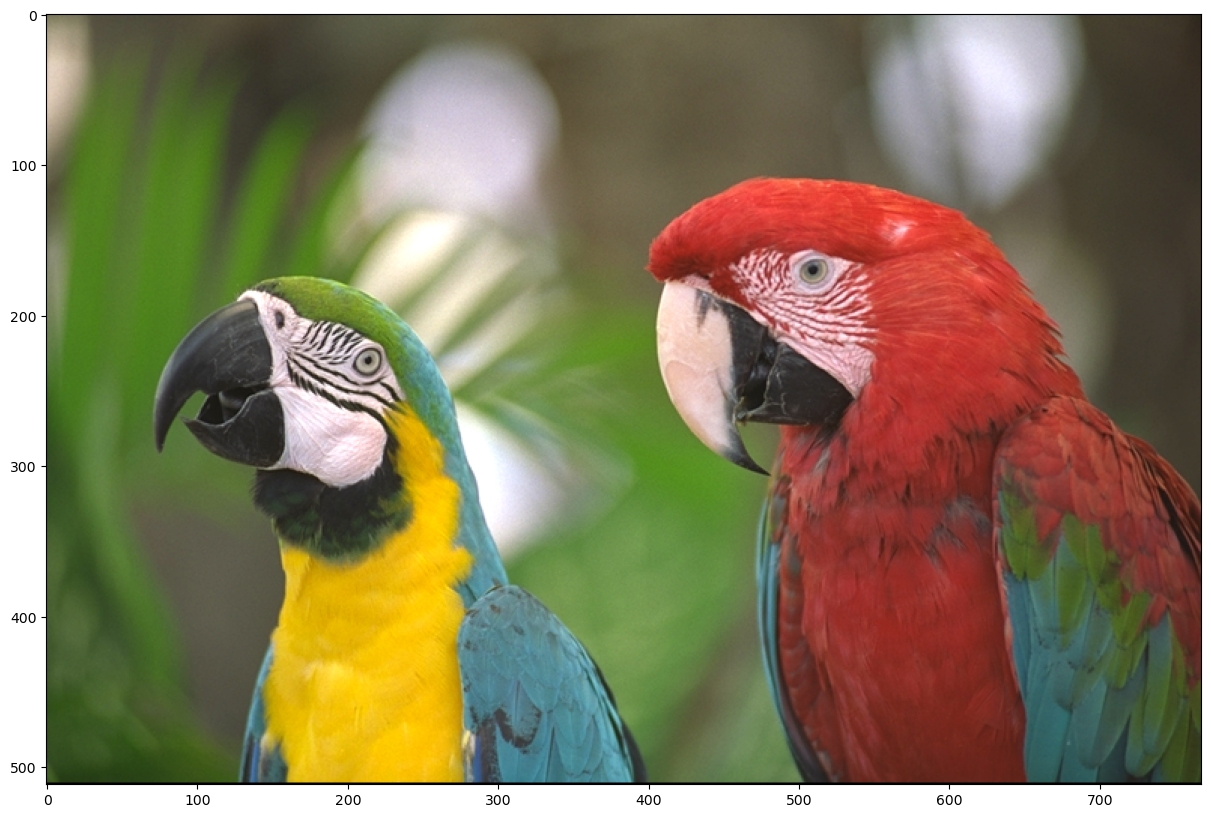

In [38]:
# Load image
img = cv2.imread('./data/kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [39]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [40]:
# Cast the image to float

# Prepare for quantization
rows, cols, channels = img.shape
print('size', rows, 'x', cols)
quantized = np.zeros_like(img)

def euclideanDistance(imgPixel, quantizePixel):
    redChannel = (imgPixel[0]-quantizePixel[0])**2
    greenChannel = (imgPixel[1]-quantizePixel[1])**2
    blueChannel = (imgPixel[2]-quantizePixel[2])**2
    return np.sqrt(redChannel+greenChannel+blueChannel)

#verify if implementation correct comparing to scipy.spatial
ownImplementaion = euclideanDistance(np.array([123, 20, 150]) / 255, colors[1])
scipyImplementaion = distance.euclidean(np.array([123, 20, 150]) / 255, colors[1])
print('Is own Euclidean Distance implemetation returns the same result as scipy:',
      'true' if ownImplementaion == scipyImplementaion else 'false')

def findClosedQuantizedPixelColour(imgPixel, colors):
    minEuclidean = distance.euclidean(imgPixel, colors[0])
    pixel = colors[0]
    for i in colors[1:len(colors)]:
        euclidean = distance.euclidean(imgPixel, i)
        pixel = i if euclidean <= minEuclidean else pixel
        minEuclidean = euclidean
    return pixel


# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r][c]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel =  findClosedQuantizedPixelColour(pixel, colors)

        # Apply quantization
        quantized[r, c, :] = new_pixel
        
print("Done")

size 512 x 768
Is own Euclidean Distance implemetation returns the same result as scipy: true
Done


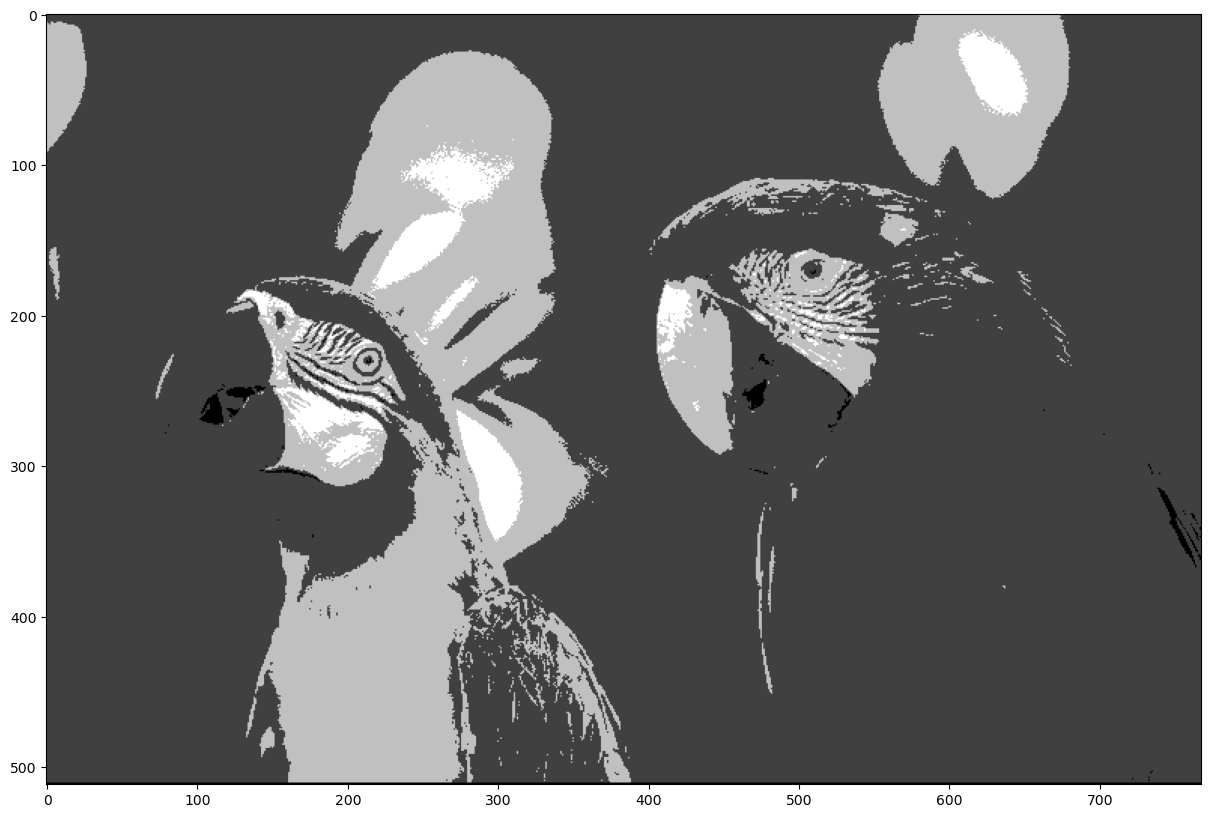

In [43]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(quantized)

In [44]:
# Compute average quantization error
avg_quant_error = np.mean(img - quantized)
print('average quantization error:', avg_quant_error)

average quantization error: 115.18359798855252


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [45]:
def dithering(img, colors):
    #progress bar related
    pixelCount = rows * cols
    label = HTML()
    progressBarIncrement = int(pixelCount / 100)
    progressBarCount = 0
    progress = IntProgress(min=0, max=100, value=0)
    progress.bar_style = 'info'
    box = VBox(children=[label, progress])
    display(box)

    # Make a temporal copy of the original image, we will need it for error diffusion
    img_tmp = np.copy(img)
    dithering = np.zeros_like(img)

    for r in range(1, rows-1):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = img_tmp[r][c]
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            new_pixel = findClosedQuantizedPixelColour(pixel, colors)        
        
            # Compute quantization error
            quant_error = (pixel - new_pixel)
        
            # Diffuse the quantization error accroding to the FS diffusion matrix
            # Note: You may need more than one line of code here
            img_tmp[r    ][c + 1] = img_tmp[r    ][c + 1] + quant_error * 7 / 16
            img_tmp[r + 1][c - 1] = img_tmp[r + 1][c - 1] + quant_error * 3 / 16
            img_tmp[r + 1][c    ] = img_tmp[r + 1][c    ] + quant_error * 5 / 16
            img_tmp[r + 1][c + 1] = img_tmp[r + 1][c + 1] + quant_error * 1 / 16
        
            # Apply dithering
            dithering[r, c, :] = new_pixel
        
            # progress bar
            progressBarCount += 1
            if progressBarCount%progressBarIncrement==0:
                val = progressBarCount/progressBarIncrement
                progress.value = val
                label.value = u'processing: {index} / {size} %'.format(index=val,size=100)

    dithering[dithering>255] = 255        
    progress.value = 100
    label.value = u'Done'
    return dithering

In [48]:
fourColoursDithering = dithering(img, colors)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1ee905057f0>)

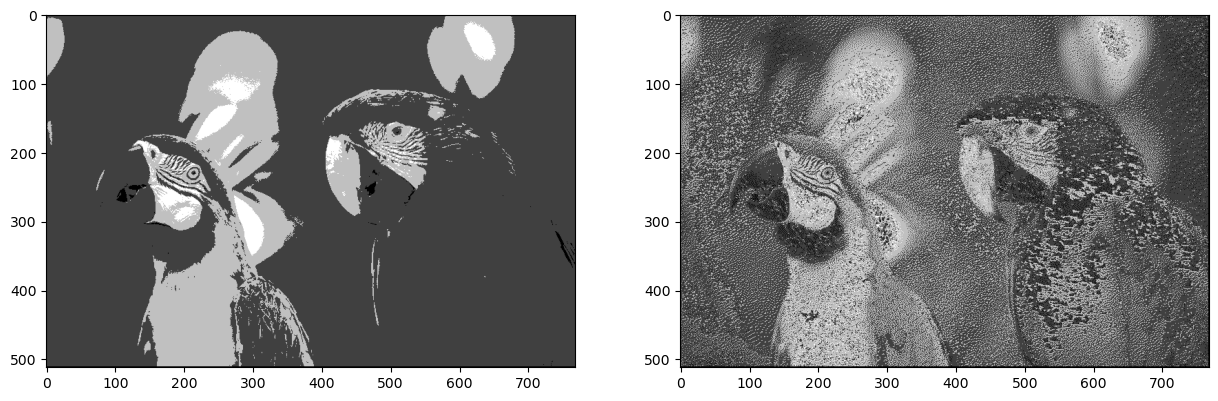

In [49]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized.astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow(fourColoursDithering.astype(np.uint8))   # dithering

In [51]:
# Compute average quantization error for dithered image
avg_dith_error =  np.mean(img - fourColoursDithering)
print('average quantization error:', avg_dith_error)

average quantization error: 118.80882347954645


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
* Which image looks better to you?
* Can you repeat the same process using only two colours: black and white? Show me :-)

### Answers
1. According to observation dithering has higher quantization error
2. Nevertheless dithering image has more datails comparing to original and looks better
3. See below

In [52]:
# Black, dark gray, light gray, white
blackWhite = np.array([[0, 0, 0],
                       [255, 255, 255]])
blackWhiteDithering = dithering(img, blackWhite)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1ee94d52a00>)

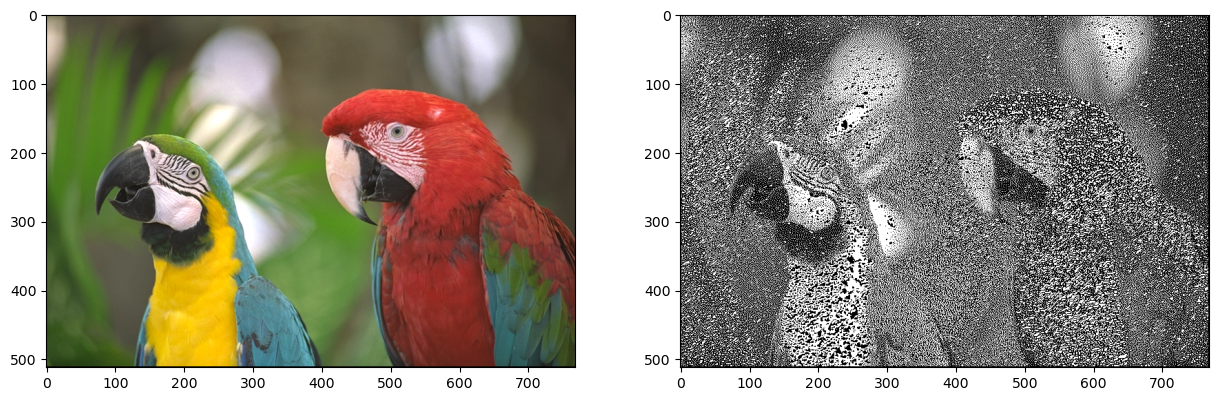

In [53]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img)   # optimally quantized
plt.subplot(122), plt.imshow(blackWhiteDithering.astype(np.uint8))   # dithering

In [54]:
# Compute average quantization error for dithered image
avg_dith_error =  np.mean(img - blackWhiteDithering)
print('average quantization error:', avg_dith_error)

average quantization error: 100.89888509114583


### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 1)))
colors = kmeans.cluster_centers_

Apply FS dithering the same way you did before.
* How does the result look like to you?
* What happens if we use 32 colours?
* And what happens if we use 256 colours?